In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from fancyimpute import IterativeImputer as mice

(CVXPY) Sep 13 06:13:32 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
df = pd.read_csv('life expectancy.csv')
df.head()

,Country Name,Country Code,Region,IncomeGroup,Year,Life Expectancy World Bank,Prevelance of Undernourishment,CO2,Health Expenditure %,Education Expenditure %,Unemployment,Corruption,Sanitation,Injuries,Communicable,NonCommunicable
0,Afghanistan,AFG,South Asia,Low income,2001,56.308,47.8,730.0,NaN,NaN,10.809000,NaN,NaN,2179727.10,9689193.70,5795426.38
1,Angola,AGO,Sub-Saharan Africa,Lower middle income,2001,47.059,67.5,15960.0,4.483516,NaN,4.004000,NaN,NaN,1392080.71,11190210.53,2663516.34
2,Albania,ALB,Europe & Central Asia,Upper middle income,2001,74.288,4.9,3230.0,7.139524,3.4587,18.575001,NaN,40.520895,117081.67,140894.78,532324.75
3,Andorra,AND,Europe & Central Asia,High income,2001,NaN,NaN,520.0,5.865939,NaN,NaN,NaN,21.788660,1697.99,695.56,13636.64
4,United Arab Emirates,ARE,Middle East & North Africa,High income,2001,74.544,2.8,97200.0,2.484370,NaN,2.493000,NaN,NaN,144678.14,65271.91,481740.70


In [3]:
df.describe()

,Year,Life Expectancy World Bank,Prevelance of Undernourishment,CO2,Health Expenditure %,Education Expenditure %,Unemployment,Corruption,Sanitation,Injuries,Communicable,NonCommunicable
count,3306.000000,3118.000000,2622.000000,3.154000e+03,3126.000000,2216.000000,3002.000000,975.000000,2059.000000,3.306000e+03,3.306000e+03,3.306000e+03
mean,2010.000000,69.748362,10.663654,1.574924e+05,6.364059,4.589014,7.890760,2.860513,52.738785,1.318219e+06,4.686289e+06,7.392488e+06
std,5.478054,9.408154,11.285897,7.726415e+05,2.842844,2.119165,6.270832,0.621343,30.126762,5.214068e+06,1.843727e+07,2.932688e+07
min,2001.000000,40.369000,2.500000,1.000000e+01,1.263576,0.850320,0.100000,1.000000,2.377647,4.304900e+02,3.301600e+02,2.481820e+03
25%,2005.000000,63.642000,2.500000,2.002500e+03,4.205443,3.136118,3.733000,2.500000,24.746007,6.245688e+04,5.776475e+04,3.184758e+05
50%,2010.000000,72.168500,6.200000,1.020500e+04,5.892352,4.371465,5.920000,3.000000,49.317481,2.456910e+05,3.147693e+05,1.350146e+06
75%,2015.000000,76.809000,14.775000,5.877250e+04,8.119166,5.519825,10.097500,3.250000,80.278847,8.465591e+05,2.831636e+06,3.918468e+06
max,2019.000000,84.356341,70.900000,1.070722e+07,24.230680,23.270000,37.250000,4.500000,100.000004,5.563676e+07,2.685646e+08,3.246378e+08


### Identifying and treating missing data

In [12]:
percent_missing = df.isnull().sum() * 100 / len(df)
only_missing = percent_missing.sort_values(ascending=False) 
only_missing = only_missing[only_missing >0]
only_missing

Corruption                        70.508167
Sanitation                        37.719298
Education Expenditure %           32.970357
Prevelance of Undernourishment    20.689655
Unemployment                       9.195402
Life Expectancy World Bank         5.686630
Health Expenditure %               5.444646
CO2                                4.597701
dtype: float64

A large portion of 'Corruption' seems to be missing followed by 'Sanitaion', 'Education expenditure', and 'Prevalence of Under Nourishment'. 

<AxesSubplot:>

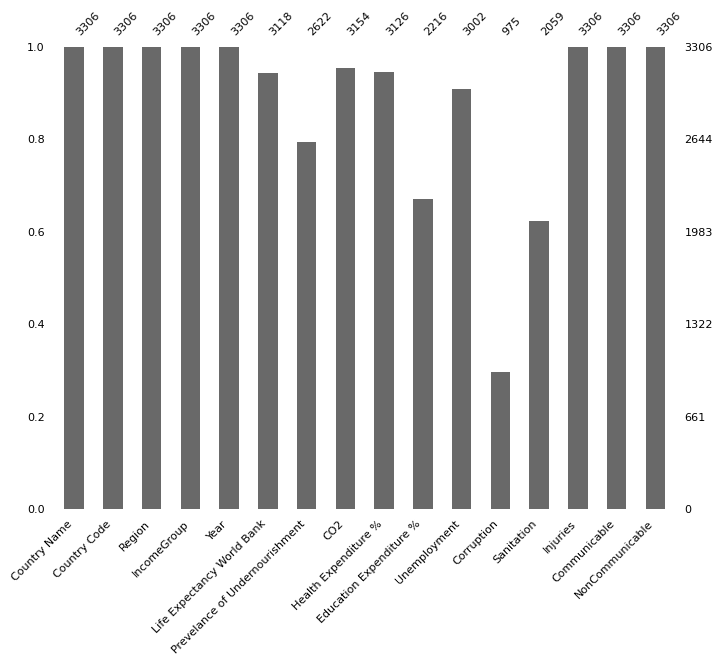

In [5]:
msno.bar(df, figsize=(8, 6), fontsize=8)

Here is the missing data visualized

<AxesSubplot:>

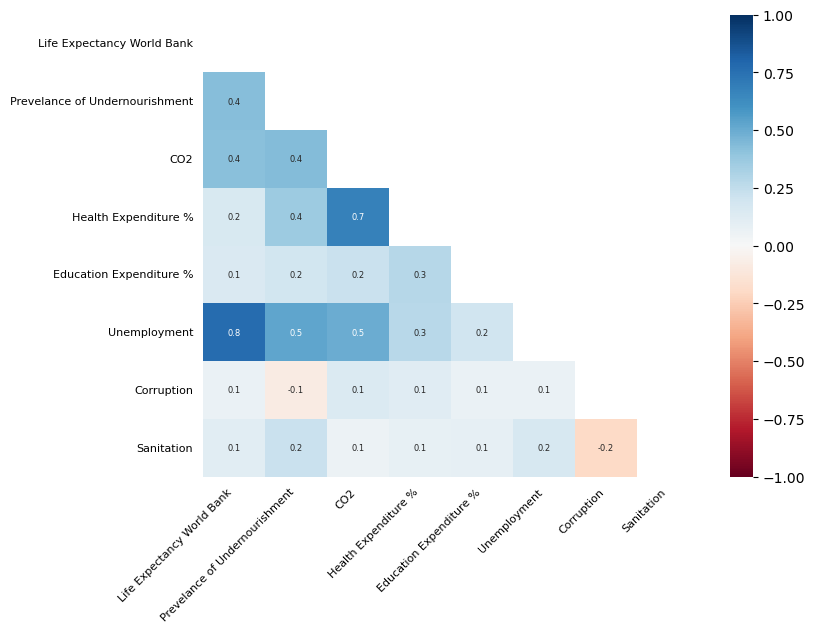

In [6]:
msno.heatmap(df, figsize=(8, 6), fontsize=8)

Above is a correlation heat map of missing data. Here we can see that unemployment and life expectancy has a value of 0.8 which means that if life expectancy has a value, there is an 80% chance that unemployment will have a missing value and vice versa.

Similar case with CO2 and health expenditure, if CO2 has a value, there is a 70% chance that health expenditure will a missing value and vice versa.

I conclude that the cause of missing data is higly likely to be within the dataset itself which makes the nature of the missing data to be Missing At Random (MAR). Therefore, I elected to use MICE imputation in order to fill in the missing data as I believe its provides a more robust and complete dataset as opposed to simpler but efficient methods such as mean imputation.

In [7]:
#store the dropped columns for later
country_name = df['Country Name']
country_code = df['Country Code']
region = df['Region']
income_group = df['IncomeGroup']

#impute the missing data from remaining columns
df_nocat = df.drop(['Country Name','Country Code', 'Region', 'IncomeGroup'], axis=1)
df_imp = mice().fit_transform(df_nocat)

# Convert the result back to DataFrame
df_imp = pd.DataFrame(df_imp, columns = df_nocat.columns)

# Add the dropped columns back to the DataFrame
df_imp['Country Name'] = country_name.values
df_imp['Country Code'] = country_code.values
df_imp['Region'] = region.values
df_imp['IncomeGroup'] = income_group.values

### Outlier Identification and Treatment

In [14]:
df_imp.dtypes

Year                              float64
Life Expectancy World Bank        float64
Prevelance of Undernourishment    float64
CO2                               float64
Health Expenditure %              float64
Education Expenditure %           float64
Unemployment                      float64
Corruption                        float64
Sanitation                        float64
Injuries                          float64
Communicable                      float64
NonCommunicable                   float64
Country Name                       object
Country Code                       object
Region                             object
IncomeGroup                        object
dtype: object

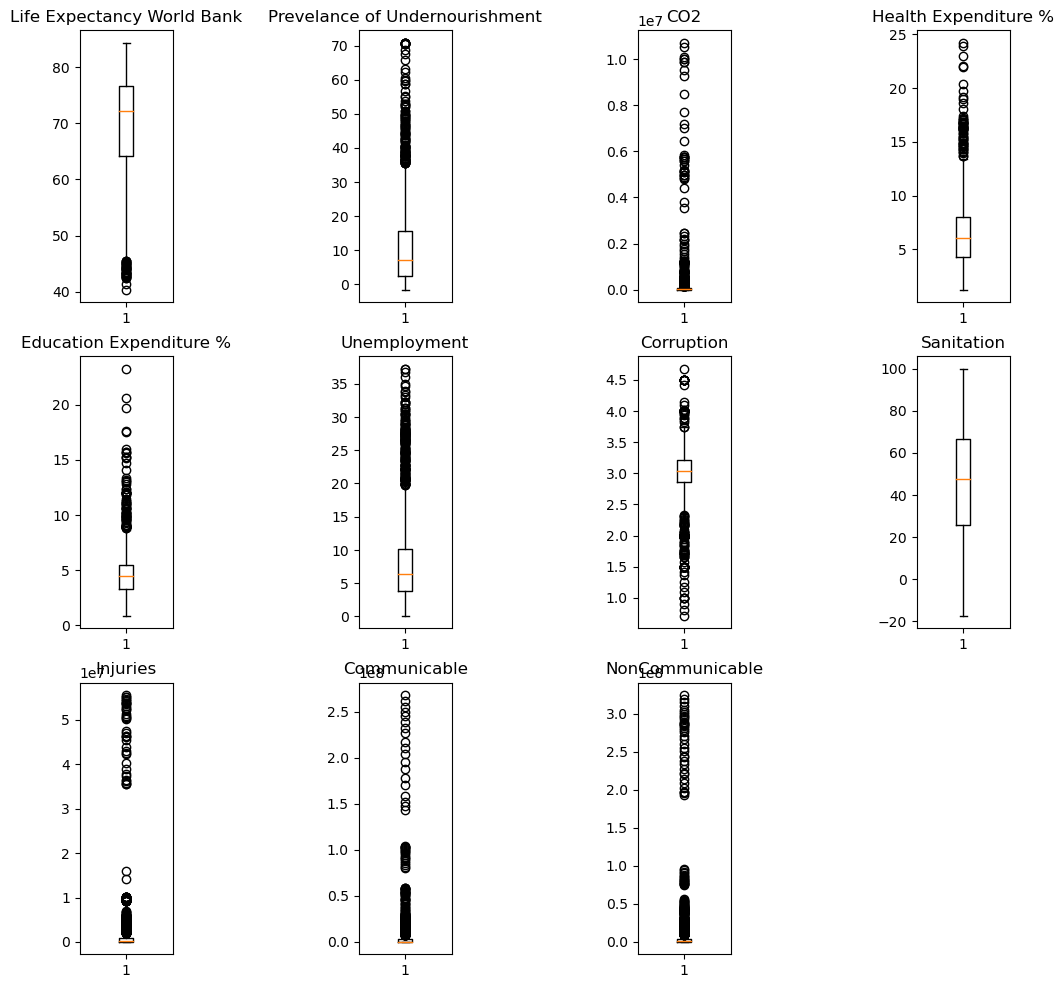

In [20]:
columns = ['Life Expectancy World Bank', 'Prevelance of Undernourishment', 'CO2', 'Health Expenditure %',
           'Education Expenditure %','Unemployment','Corruption','Sanitation','Injuries','Communicable','NonCommunicable']
n_cols = 4
n_rows = 3

# Initialize subplot index
subplot_index = 1

# Create the figure
plt.figure(figsize=(12, 12))

# for each column in columns, make a boxplot
for column in columns:
    plt.subplot(n_rows, n_cols, subplot_index)
    plt.boxplot(df_imp[column])
    plt.title(f'{column}')
    
    # Increment subplot index for the next loop iteration
    subplot_index += 1

# Show the plot
plt.subplots_adjust(wspace=2) 
plt.show()

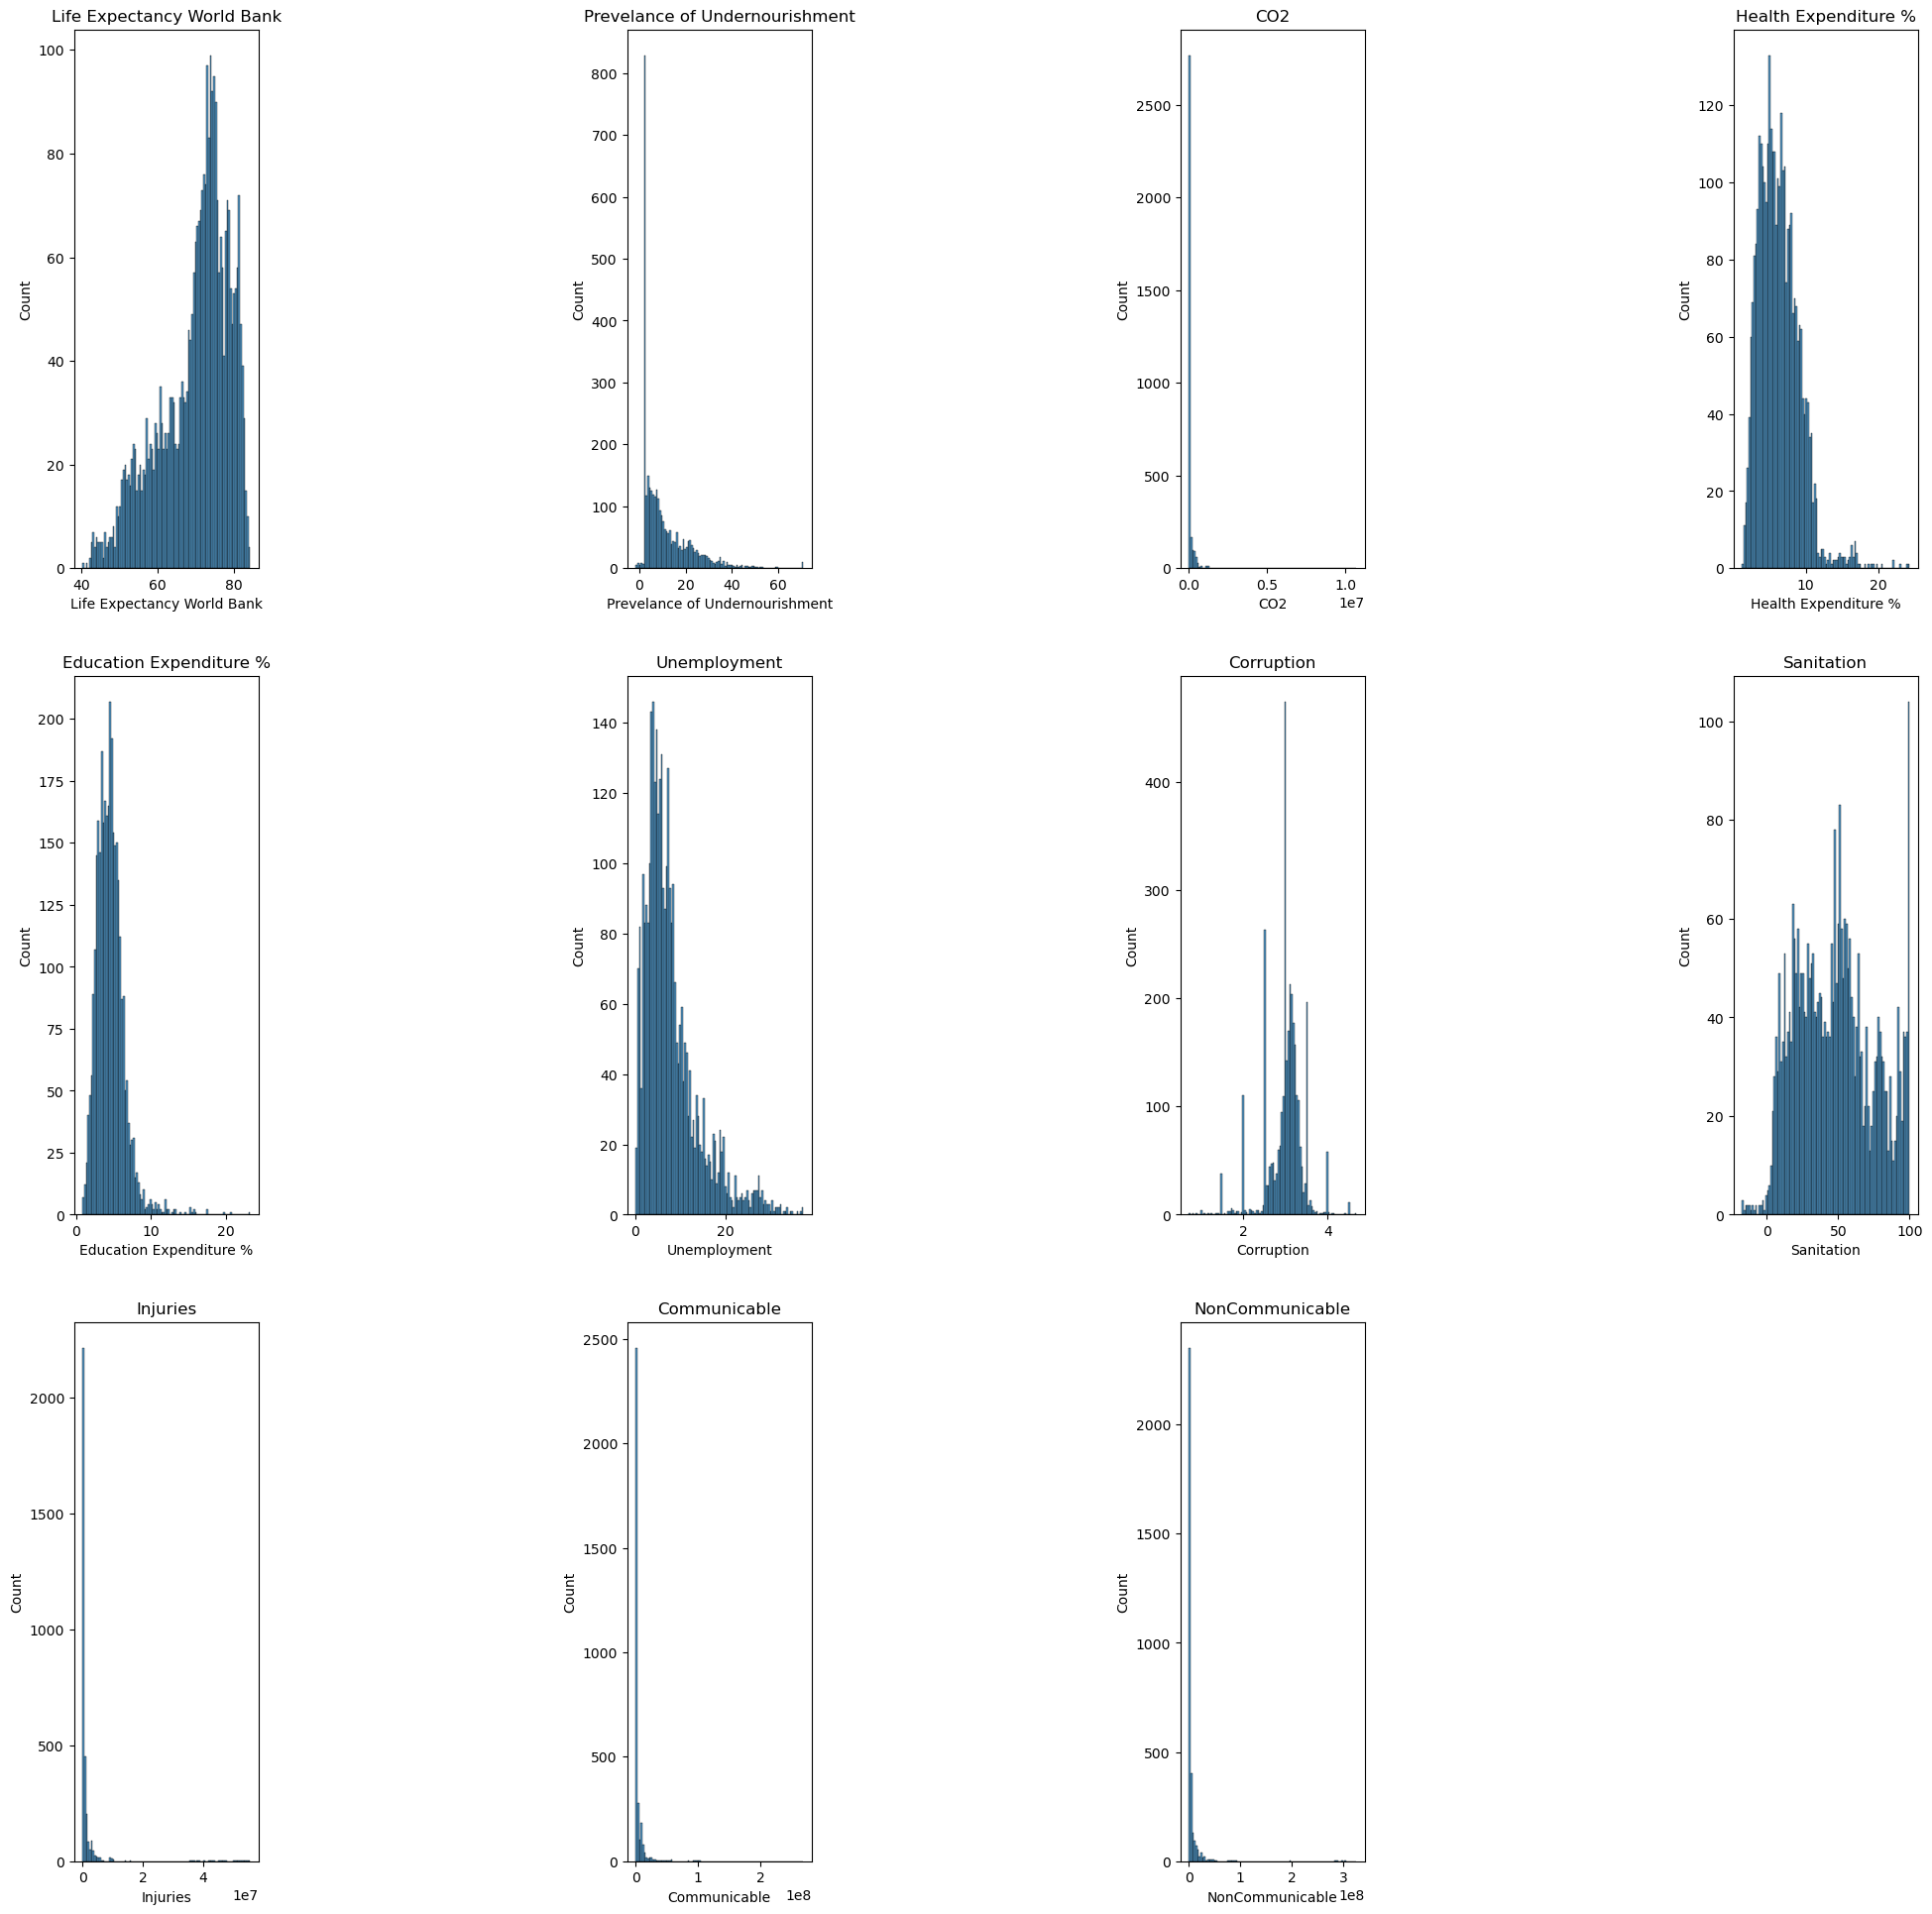

In [22]:
columns = ['Life Expectancy World Bank', 'Prevelance of Undernourishment', 'CO2', 'Health Expenditure %',
           'Education Expenditure %','Unemployment','Corruption','Sanitation','Injuries','Communicable','NonCommunicable']
n_cols = 4
n_rows = 3

# Initialize subplot index
subplot_index = 1

# Create the figure
plt.figure(figsize=(24, 24))

# for each column in columns, make a boxplot
for column in columns:
    plt.subplot(n_rows, n_cols, subplot_index)
    sns.histplot(df_imp[column],bins = 100)
    plt.title(f'{column}')
    
    # Increment subplot index for the next loop iteration
    subplot_index += 1

# Show the plot
plt.subplots_adjust(wspace=2) 
plt.show()

### Categorical Variables Analysis

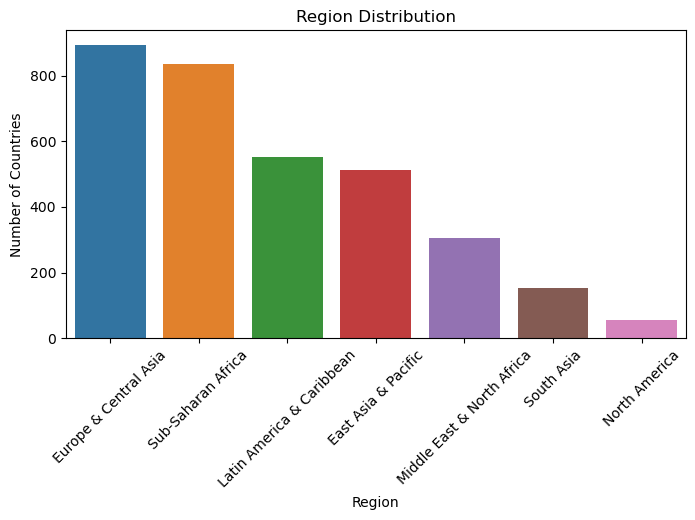

In [8]:
#Country name Bar plot
regions = df_imp.groupby(['Region'])['Country Name'].size().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x = regions.index, y = regions.values)
plt.xlabel("Region")
plt.ylabel("Number of Countries")
plt.title("Region Distribution")
plt.xticks(rotation=45)
plt.show()

In [9]:
region_class = df_imp.groupby(['Region','IncomeGroup']).size()
region_class

Region                      IncomeGroup        
East Asia & Pacific         High income            133
                            Lower middle income    209
                            Upper middle income    171
Europe & Central Asia       High income            589
                            Lower middle income     57
                            Upper middle income    247
Latin America & Caribbean   High income            133
                            Lower middle income     95
                            Upper middle income    323
Middle East & North Africa  High income            152
                            Lower middle income     95
                            Upper middle income     57
North America               High income             57
South Asia                  Low income              19
                            Lower middle income    114
                            Upper middle income     19
Sub-Saharan Africa          High income             19
                 

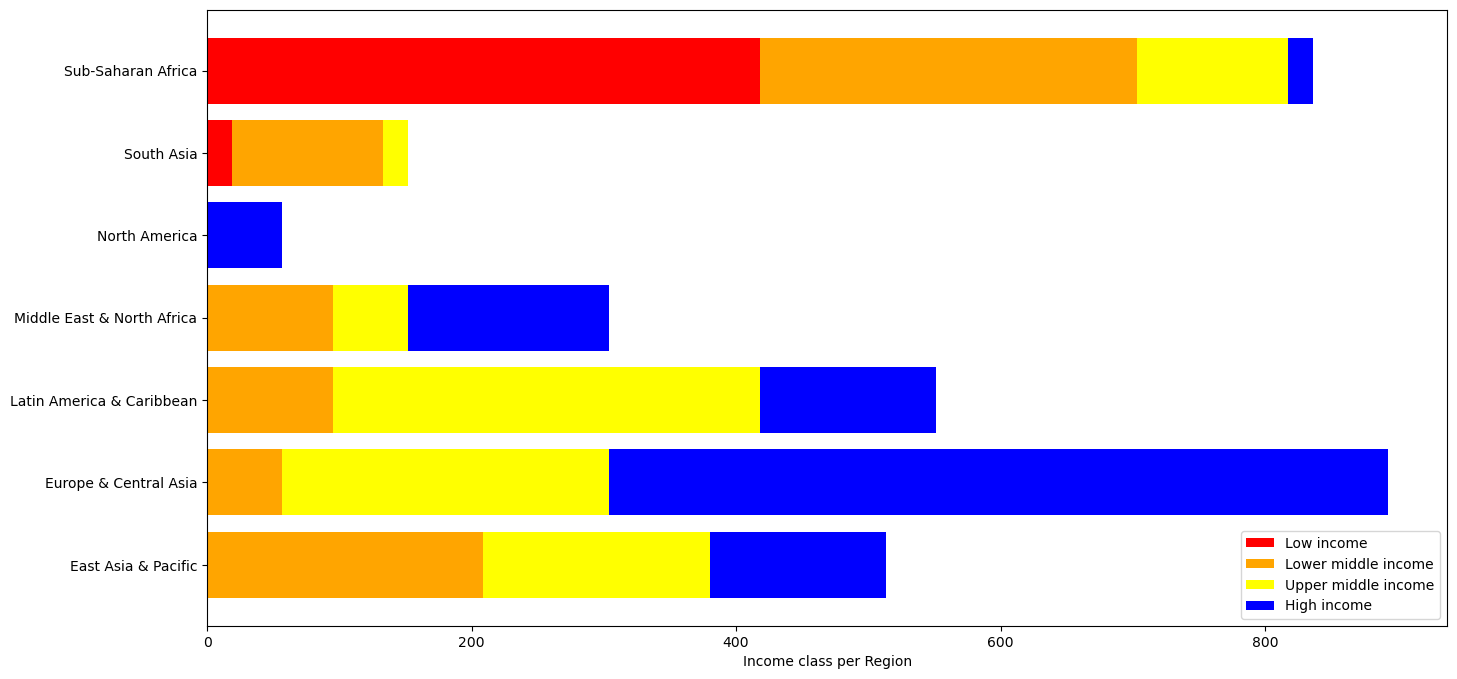

In [10]:
region = df_imp[['Region','IncomeGroup']]
region_c = region.pivot_table(index='Region', columns='IncomeGroup', aggfunc='size', fill_value=0)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(16, 8))

# Create the bar plots
ax.barh(region_c.index, region_c['Low income'], label='Low income', color='red')
ax.barh(region_c.index, region_c['Lower middle income'], left=region_c['Low income'], label='Lower middle income', color='orange')
ax.barh(region_c.index, region_c['Upper middle income'], left=region_c['Low income'] + region_c['Lower middle income'], label='Upper middle income', color='yellow')
ax.barh(region_c.index, region_c['High income'], left=region_c['Low income'] + region_c['Lower middle income'] + region_c['Upper middle income'], label='High income', color='blue')

# Add a legend and informative axis label
ax.legend(loc='lower right')
ax.set_xlabel('Income class per Region')

# Show plot
plt.show()

line graph comparing yearly life expecntacies of each country